# Yarrowia Media Matrix 

### Takes generated media matrix and clusters groups for dimensionality reduction. Arbitrarily sets bounds and cluster groups, then uses LHS to sample points within bounds for initial experimental set.

#### this file is mostly copied from 'Yarrowia linear hierarchial tree reduction.ipynb' from ML_for_rational_design repo

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram

In [28]:
# read in mol/L data for dimensional reduction
df = pd.read_csv("data/Media-Matrix-Combined-v5-grams-per-litre.csv")

# filter rows that are considered not important
compounds_to_remove = [
    'Dipotassium phosphate', 'Disodium edta dihydrate', 'EDTA', 'Monopotassium phosphate',
    'Phosphoric acid', 'Potassium hydroxide', 'Sodium citrate dihydrate', 'Sodium phosphate',
    'Sulphuric acid', 'Uracil'
]

df = df[~df['Compound'].isin(compounds_to_remove)].copy()

# remove pubchemid
df.drop(df.columns[1], axis=1, inplace=True)

# separate numeric columns for transformation
num_df = df.select_dtypes(include='number')
labels = df[['Compound', 'Annotate']]

yar_df = df.filter(like='_YAR')
#cer_df = df_log.filter(like='_CER')
#pic_df = df_log.filter(like='_PIC')

yar_df_labeled = pd.concat([labels, yar_df], axis=1)

# Define which columns are sample measurements (everything except metadata)
sample_cols = yar_df_labeled.columns.difference(['Compound', 'Annotate'])

# Filter to keep rows where at least one sample value ≠ 0   # this bit was changed for the linear version of this process pipeline
yar_df_labeled = yar_df_labeled[
    yar_df_labeled['Annotate'].isin(['Vitamin', 'Element']) &
    ~(yar_df_labeled[sample_cols] == 0).all(axis=1)
].copy()

# let's remove redundant elements for calcium iron, manganese, sodium chloride and zinc chloride
yar_df_labeled = yar_df_labeled.drop(index=[9, 16, 29, 35, 46, 59])

yar_df_element = yar_df_labeled[yar_df_labeled['Annotate'] == 'Element'].copy()
yar_df_vitamin = yar_df_labeled[yar_df_labeled['Annotate'] == 'Vitamin'].copy()


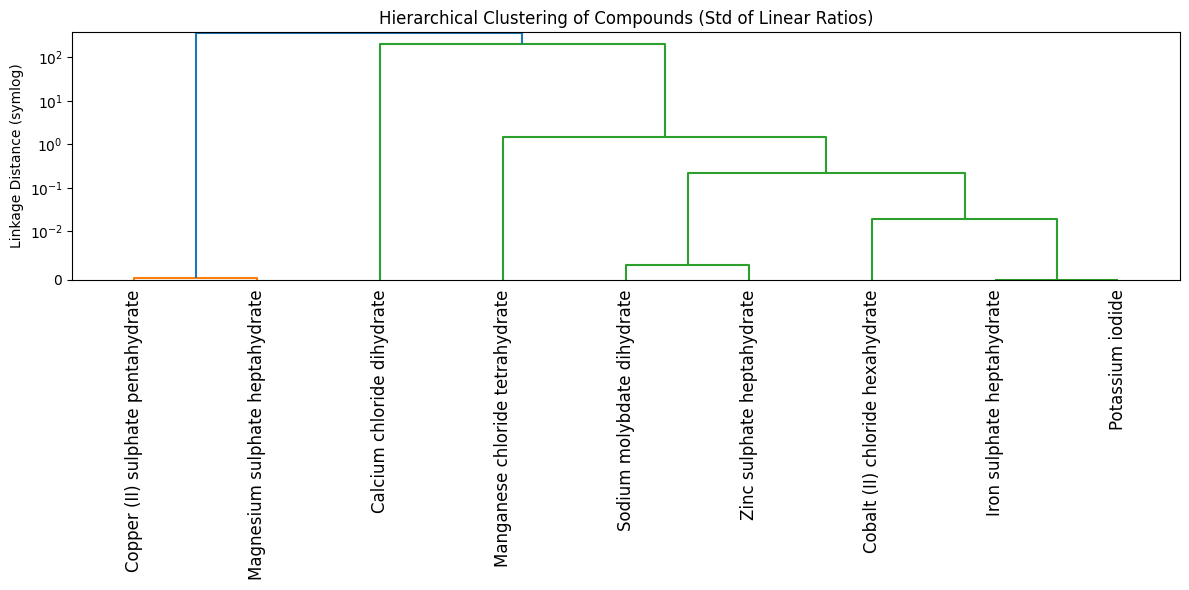

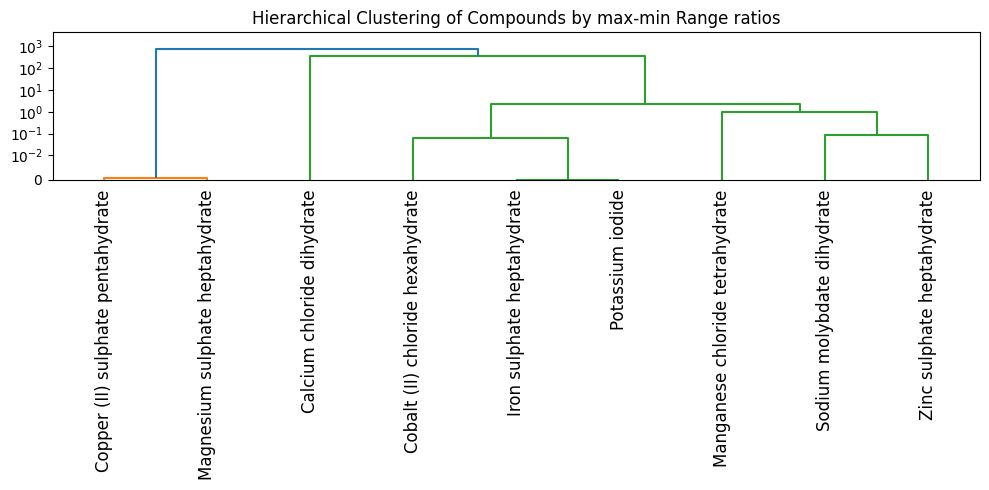

 Step  Cluster_ID                                                                 Merged_Cluster_1                                                                                                                                                                                      Merged_Cluster_2  Linkage_Distance  Num_Compounds
    1           9                                                     [Iron sulphate heptahydrate]                                                                                                                                                                                    [Potassium iodide]          0.000000              2
    2          10                                              [Copper (II) sulphate pentahydrate]                                                                                                                                                                     [Magnesium sulphate heptahydrate]          0.000520              2
    3     

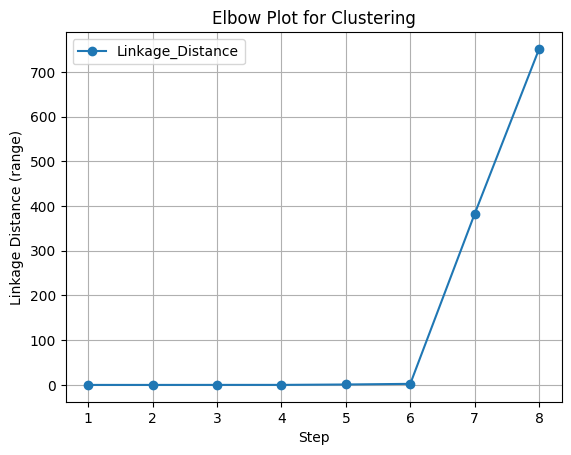

In [31]:
df_e = yar_df_element.copy()
sample_cols = df_e.columns.difference(['Compound', 'Annotate'])

ratios = []


# all unique compound pairs
compound_pairs = list(itertools.combinations(df_e['Compound'], 2))

# map for quick lookup
compound_map = df_e.set_index('Compound')[sample_cols]

# loop through pairs
for c1, c2 in compound_pairs:
    vals1 = compound_map.loc[c1]
    vals2 = compound_map.loc[c2]

    # per-column mask
    valid_mask = (vals1>0) & (vals2 >0)
    ratio = vals1/vals2 #

    #only keeps valid entries
    ratio_filtered = ratio.where(valid_mask)

    # store as a row with all per-column ratios
    row = {
        'Compound_1': c1,
        'Compound_2': c2,
        **ratio_filtered.to_dict()
    }
    ratios.append(row)

# create a dataframe
ratio_df_e = pd.DataFrame(ratios)

#ratio_df_e_reduced = ratio_df_e.drop(columns = ['1_YAR', '2b_YAR', '2c_YAR', '2d_YAR', '3b_YAR', '3c_YAR']) 
ratio_df_e_reduced = ratio_df_e.drop(columns = ['1_YAR', '2b_YAR', '2c_YAR', '2d_YAR', '3b_YAR', '3c_YAR', '6_YAR']) 
# to remove 2b to 2d Yar (which are the same as 2a) and 3b(which was all nans) 3c was dropped as it was focused on protein yiedl rather than hcd/growth
# I've also removed 1_YAR as it is out of whack compared to others
#6_YAR is removed, though it was added as it's the origin paper for 3c, which was found to be inconsistent

# Step 1: Compute SD per row
sample_cols = ratio_df_e_reduced.columns.difference(['Compound_1', 'Compound_2'])
ratio_df_e_reduced['Std_Ratio'] = ratio_df_e_reduced[sample_cols].replace(0, np.nan).std(axis=1, skipna=True)

# Step 2: Create list of all unique compounds
compounds = pd.unique(ratio_df_e_reduced[['Compound_1', 'Compound_2']].values.ravel())

# Step 3: Initialize empty distance matrix
distance_matrix = pd.DataFrame(np.nan, index=compounds, columns=compounds)

# Step 4: Fill matrix with std values (symmetric)
for _, row in ratio_df_e_reduced.iterrows():
    c1, c2, std = row['Compound_1'], row['Compound_2'], row['Std_Ratio']
    distance_matrix.loc[c1, c2] = std
    distance_matrix.loc[c2, c1] = std

# Step 5: Set diagonal to 0
np.fill_diagonal(distance_matrix.values, 0)

# Step 6: Check for missing values
if distance_matrix.isnull().any().any():
    raise ValueError("Distance matrix contains NaNs — some compound pairs are missing.")

# Step 7: Run hierarchical clustering
condensed_dist = squareform(distance_matrix.values)
Z = linkage(condensed_dist, method='average')

# Step 8: Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=distance_matrix.index.tolist(), leaf_rotation=90)#, color_threshold=100)
plt.yscale('symlog', linthresh=.01)
plt.ylabel("Linkage Distance (symlog)")
plt.title("Hierarchical Clustering of Compounds (Std of Linear Ratios)")
plt.tight_layout()
plt.show()


'''Below generates the max-min range ratios which makes sense as with so 
few experiments remaining after removal of invalids and redundants'''
# in this instance, the two plots should be virutally identical

# select only numeric columns excluding compound ID columns
numeric_cols = ratio_df_e_reduced.drop(columns=['Compound_1', 'Compound_2']).select_dtypes(include='number').columns

# create new dataframe with range values
range_df_e = pd.DataFrame({
    'Compound_1': ratio_df_e_reduced['Compound_1'],
    'Compound_2': ratio_df_e_reduced['Compound_2'],
    'range': ratio_df_e_reduced[numeric_cols].replace(0, np.nan).max(axis=1) - ratio_df_e_reduced[numeric_cols].replace(0, np.nan).min(axis=1)
})

# Create a square distance matrix
compounds = pd.unique(range_df_e[['Compound_1', 'Compound_2']].values.ravel())
distance_matrix = pd.DataFrame(0, index=compounds, columns=compounds, dtype=float)

# Fill in distances symmetrically
for _, row in range_df_e.iterrows():
    c1, c2, dist = row['Compound_1'], row['Compound_2'], row['range']
    distance_matrix.loc[c1, c2] = dist
    distance_matrix.loc[c2, c1] = dist

# Ensure zero diagonal
np.fill_diagonal(distance_matrix.values, 0)

if distance_matrix.isnull().any().any():
    raise ValueError("Distance matrix contains NaNs — some compound pairs are missing.")

# Convert square matrix to condensed distance matrix
condensed_dist = squareform(distance_matrix.values)

# Perform hierarchical clustering
Z = linkage(condensed_dist, method='average')

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z, labels=distance_matrix.index.tolist(), leaf_rotation=90)
plt.title("Hierarchical Clustering of Compounds by max-min Range ratios")
plt.yscale('symlog', linthresh=0.01)
plt.ylim(0, distance_matrix.values.max() * 1.2)
plt.tight_layout()
plt.show()



''' this section generates a table of merge steps for the hierarchical clustering'''
# Get compound names
compounds = list(distance_matrix.index)

# Number of original observations
n = len(compounds)

# This will store merge history
merge_history = []

# Track cluster membership (compound names or merged groups)
clusters = {i: [compounds[i]] for i in range(n)}

# Loop over linkage matrix Z
for step, (idx1, idx2, dist, sample_count) in enumerate(Z):
    idx1, idx2 = int(idx1), int(idx2)
    
    # Get the clusters being merged
    members1 = clusters[idx1]
    members2 = clusters[idx2]

    # Merge the two clusters
    new_cluster = members1 + members2
    clusters[n + step] = new_cluster

    # Save merge info
    merge_history.append({
        'Step': step + 1,
        'Cluster_ID': n + step,
        'Merged_Cluster_1': members1,
        'Merged_Cluster_2': members2,
        'Linkage_Distance': dist,
        'Num_Compounds': len(new_cluster),
    })

# Convert to dataframe for easier viewing
merge_df = pd.DataFrame(merge_history)

# Display the merge table sorted by step (or by distance, if you prefer)
merge_df_sorted = merge_df.sort_values('Linkage_Distance', ascending=True)

# Print the table or write to CSV
print(merge_df_sorted.to_string(index=False))
# merge_df_sorted.to_csv("compound_merge_steps.csv", index=False)

merge_df_sorted[['Step', 'Linkage_Distance']].plot(x='Step', y='Linkage_Distance', marker='o')
plt.ylabel("Linkage Distance (range)")
plt.title("Elbow Plot for Clustering")
plt.grid(True)
plt.show()


Vitamin hierarchical tree (same as above which was for elements)

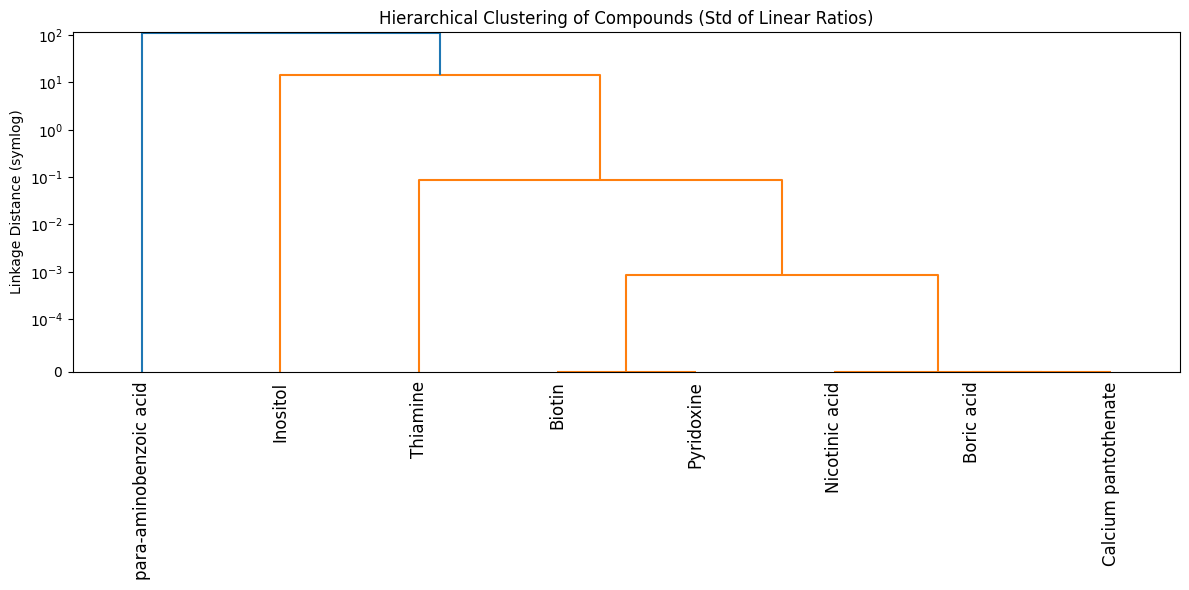

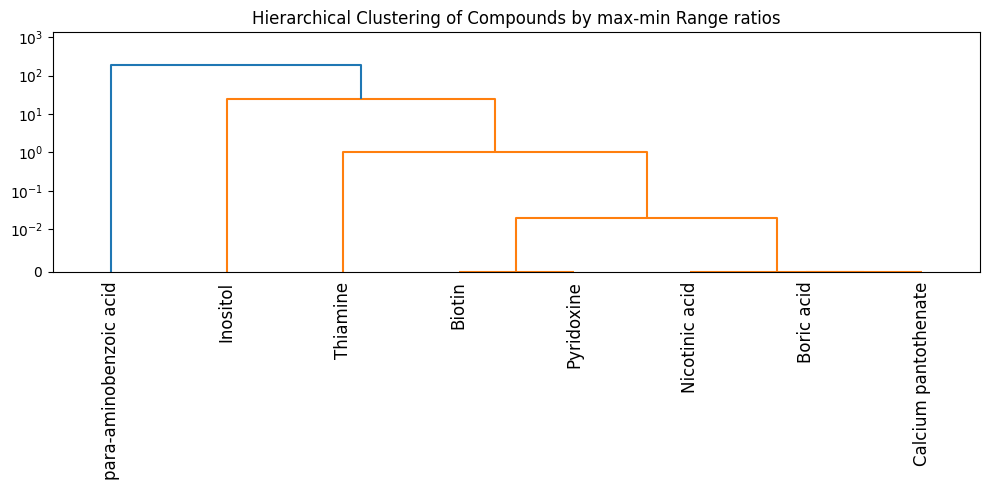

 Step  Cluster_ID         Merged_Cluster_1                                                                           Merged_Cluster_2  Linkage_Distance  Num_Compounds
    1           8                 [Biotin]                                                                               [Pyridoxine]          0.000000              2
    2           9             [Boric acid]                                                                     [Calcium pantothenate]          0.000000              2
    3          10         [Nicotinic acid]                                                         [Boric acid, Calcium pantothenate]          0.000000              3
    4          11     [Biotin, Pyridoxine]                                         [Nicotinic acid, Boric acid, Calcium pantothenate]          0.019967              5
    5          12               [Thiamine]                     [Biotin, Pyridoxine, Nicotinic acid, Boric acid, Calcium pantothenate]          1.003517              

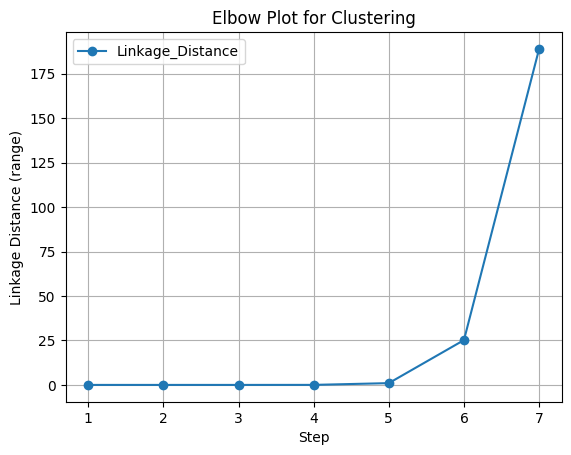

In [32]:
df_v = yar_df_vitamin.copy()
sample_cols = df_v.columns.difference(['Compound', 'Annotate'])

ratios = []


# all unique compound pairs
compound_pairs = list(itertools.combinations(df_v['Compound'], 2))

# map for quick lookup
compound_map = df_v.set_index('Compound')[sample_cols]

# loop through pairs
for c1, c2 in compound_pairs:
    vals1 = compound_map.loc[c1]
    vals2 = compound_map.loc[c2]

    # per-column mask
    valid_mask = (vals1>0) & (vals2 >0)
    ratio = vals1/vals2 

    #only keeps valid entries
    ratio_filtered = ratio.where(valid_mask)

    # store as a row with all per-column ratios
    row = {
        'Compound_1': c1,
        'Compound_2': c2,
        **ratio_filtered.to_dict()
    }
    ratios.append(row)

# create a dataframe
ratio_df_v = pd.DataFrame(ratios)

# drop these as they are simply repeats (this study varies carbon and nitrogen source which will be constant for our purposes)
# 1_YAR also removed
# note that 3b is kept for vitamins (but not for elements) as not everything was nans.
#6_YAR removed as it is a protein expression study like 3c
ratio_df_v_reduced = ratio_df_v.drop(columns=['1_YAR','2b_YAR', '2c_YAR', '2d_YAR', '3c_YAR', '6_YAR'])

# Step 1: Compute SD per row
sample_cols = ratio_df_v_reduced.columns.difference(['Compound_1', 'Compound_2'])
ratio_df_v_reduced['Std_Ratio'] = ratio_df_v_reduced[sample_cols].replace(0, np.nan).std(axis=1, skipna=True) # added replace 0 for correct std calc

# Step 2: Create list of all unique compounds
compounds = pd.unique(ratio_df_v_reduced[['Compound_1', 'Compound_2']].values.ravel())

# Step 3: Initialize empty distance matrix
distance_matrix = pd.DataFrame(np.nan, index=compounds, columns=compounds)

# Step 4: Fill matrix with std values (symmetric)
for _, row in ratio_df_v_reduced.iterrows():
    c1, c2, std = row['Compound_1'], row['Compound_2'], row['Std_Ratio']
    distance_matrix.loc[c1, c2] = std
    distance_matrix.loc[c2, c1] = std

# Step 5: Set diagonal to 0
np.fill_diagonal(distance_matrix.values, 0)

# Step 6: Check for missing values
if distance_matrix.isnull().any().any():
    raise ValueError("Distance matrix contains NaNs — some compound pairs are missing.")

# Step 7: Run hierarchical clustering
condensed_dist = squareform(distance_matrix.values)
Z = linkage(condensed_dist, method='average')

# Step 8: Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=distance_matrix.index.tolist(), leaf_rotation=90)
plt.yscale('symlog', linthresh=.0001)
plt.ylabel("Linkage Distance (symlog)")
plt.title("Hierarchical Clustering of Compounds (Std of Linear Ratios)")
plt.tight_layout()
plt.show()



'''min-max range ratios for vitamins below'''

# select only numeric columns excluding compound ID columns
numeric_cols = ratio_df_v_reduced.drop(columns=['Compound_1', 'Compound_2']).select_dtypes(include='number').columns

# create new dataframe with range values
range_df_v = pd.DataFrame({
    'Compound_1': ratio_df_v_reduced['Compound_1'],
    'Compound_2': ratio_df_v_reduced['Compound_2'],
    'range': ratio_df_v_reduced[numeric_cols].replace(0, np.nan).max(axis=1) - ratio_df_v_reduced[numeric_cols].replace(0, np.nan).min(axis=1)
})

# Create a square distance matrix
compounds = pd.unique(range_df_v[['Compound_1', 'Compound_2']].values.ravel())
distance_matrix = pd.DataFrame(0, index=compounds, columns=compounds, dtype=float)

# Fill in distances symmetrically
for _, row in range_df_v.iterrows():
    c1, c2, dist = row['Compound_1'], row['Compound_2'], row['range']
    distance_matrix.loc[c1, c2] = dist
    distance_matrix.loc[c2, c1] = dist

# Ensure zero diagonal
np.fill_diagonal(distance_matrix.values, 0)

if distance_matrix.isnull().any().any():
    raise ValueError("Distance matrix contains NaNs — some compound pairs are missing.")

# Convert square matrix to condensed distance matrix
condensed_dist = squareform(distance_matrix.values)

# Perform hierarchical clustering
Z = linkage(condensed_dist, method='average')

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z, labels=distance_matrix.index.tolist(), leaf_rotation=90)
plt.title("Hierarchical Clustering of Compounds by max-min Range ratios")
plt.yscale('symlog', linthresh=0.01)
plt.ylim(0, distance_matrix.values.max() * 1.2)
plt.tight_layout()
plt.show()

'''this bit generates the merge table for the hierarchical clustering'''
# Get compound names
compounds = list(distance_matrix.index)

# Number of original observations
n = len(compounds)

# This will store merge history
merge_history = []

# Track cluster membership (compound names or merged groups)
clusters = {i: [compounds[i]] for i in range(n)}

# Loop over linkage matrix Z
for step, (idx1, idx2, dist, sample_count) in enumerate(Z):
    idx1, idx2 = int(idx1), int(idx2)
    
    # Get the clusters being merged
    members1 = clusters[idx1]
    members2 = clusters[idx2]

    # Merge the two clusters
    new_cluster = members1 + members2
    clusters[n + step] = new_cluster

    # Save merge info
    merge_history.append({
        'Step': step + 1,
        'Cluster_ID': n + step,
        'Merged_Cluster_1': members1,
        'Merged_Cluster_2': members2,
        'Linkage_Distance': dist,
        'Num_Compounds': len(new_cluster),
    })

# Convert to dataframe for easier viewing
merge_df = pd.DataFrame(merge_history)

# Display the merge table sorted by step (or by distance, if you prefer)
merge_df_sorted = merge_df.sort_values('Linkage_Distance', ascending=True)

# Print the table or write to CSV
print(merge_df_sorted.to_string(index=False))
# merge_df_sorted.to_csv("compound_merge_steps.csv", index=False)

merge_df_sorted[['Step', 'Linkage_Distance']].plot(x='Step', y='Linkage_Distance', marker='o')
plt.ylabel("Linkage Distance (range)")
plt.title("Elbow Plot for Clustering")
plt.grid(True)
plt.show()
